```{index} single: application; energy systems
```
```{index} single: solver; highs
```
```{index} pandas dataframe
```
```{index} network optimization
```
```{index} networkx
```
```{index} scenario analysis
```

# Extra material: Energy dispatch problem

To meet the energy demand, power plants run day and night across the country to produce electricity from a variety of sources such as fossil fuels and renewable energy. On the short-time scale, the best operating levels for electric power plants are derived every 15 minutes by solving the so-called *Optimal Power Flow (OPF)* model. The OPF model is an optimization problem with the objective of minimizing the total energy dispatching cost, while ensuring that the generation meets the total energy demand. Furthermore, the model takes into account many constraints, among which operational and physical constraints.


In [20]:
# install dependencies and select solver
%pip install -q amplpy matplotlib networkx numpy pandas

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## Background: Power networks and power flow physics

We model the nation-wide transmission power network as a directed graph $G=(V, E)$, where $V$ represents the set of nodes (e.g., cities, industrial districts, power plants) and $E$ denotes the set of directed edges (e.g., physical transmission lines).

Each node $i \in V$ has a power injection $p_i$ and demand $d_i$. The set of nodes are separated into *generator* and *load* nodes. The set of generators $\mathcal{G} \subseteq V$ corresponds to the nodes $i \in V$ for which $p_i \geq 0$ and $d_i = 0$. Each generator $i \in \mathcal{G}$ has a minimum $p_i^{\min}$ and maximum $p_i^{\max}$ production capacity. The set of load nodes $\mathcal{D} \subseteq V$ corresponds to the nodes for which $p_i = 0$ and $d_i \geq 0$. The load nodes thus correspond to the places where electricity is being consumed, e.g., cities and industrial districts. We say that supply and demand is *matched* if $\sum_{i \in V} p_i - d_i = 0$. Since we cannot store electricity in large volumes, supply must meet demand at all times, hence adjusting to it every 15 minutes by solving the OPF.

Each edge $(i, j) \in E$ carries a *power flow* $f_{ij} \in R$ and has a capacity $f_{ij}^{\max} \geq 0$, i.e., the maximum power flow that it may carry. Note that our choice to model a *directed* graph is to make the modeling of the network easier. In particular, a directed edge $(i,j)$ may carry a 'negative' flow $f_{ij} < 0$, which implies that there is flow going from $j$ to $i$ where $f_{ji} = -f_{ij}$. The capacity does not depend on the direction of the flow, implying that the flow capacity constraints are given by $|f_{ij}| = |f_{ji}| \leq f_{ij}^{\max}$.

One crucial difference of power flow problems compared to typical network flow problems is that the power flows cannot be controlled directly. Instead, as you might recall from high-school physics, the power flows are determined by the laws of electricity, which we will now present as the *power flow equations*. Ignore for a moment the flow capacity constraints. Let $\theta_{i} \in \mathbb{R}$ denote the *phase angle* of node $i$. For each edge $(i,j)$, let $b_{ij} > 0$ denote the *line susceptance*. Assuming that supply and demand is matched, i.e., $\sum_{i=1}^{n} p_i - d_i = 0$, the power flows $\mathbf{f} \in \mathbb{R}^{m}$ and phase angles $\mathbf{\theta} \in \mathbb{R}^{n}$ are obtained by solving the following linear system of equations:

$$\begin{align}
p_i - d_i &= \sum_{j: (i, j) \in E} f_{ij} - \sum_{j: (j, i) \in E} f_{ji}, & \forall \, i \in V,\\
  f_{ij} &=  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E.
\end{align}$$

The first set of constraints ensures flow conservation and the second set of constrations captures the flow dependency on susceptances and angle differences. The DC power flow equations admit a unique power flow solution $\mathbf{f}$ given matched power injections $\mathbf{p}$ and demand $\mathbf{d}$.

For a given matched supply and demand vector $\mathbf{p}$ and $\mathbf{d}$, we can compute the power flows on the network by solving the linear equations as described above. There are exactly $|V|$ and $|E|$ equations for the $\theta_i$ variables and $f_{ij}$ variables, meaning that this system of equations admit a solution.

## Optimal Power Flow
We assumed above that the power injections $\mathbf{p}$ were given. However, in practice, the power injections need to be determined for each generator in the power network, where some types of generators may be cheaper than others. Moreover, we need to take into account operational constraints, such as the maximum flow and generator limits.

On the short-time scale, the power injections are calculated for each generator by solving the so-called *Optimal Power Flow (OPF)* problem. The goal of the OPF problem is to determine a solution $(\mathbf{p}, \mathbf{f}, \mathbf{\theta})$ with minimal costs such that:
- Supply meets demand
- Line capacity constraints are met
- Generator capacity constraints are met

Let $c_i > 0$ be the cost associated with the production of a unit energy by generator $i$. Then, the OPF problem can be formulated as

$$\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i \\
\text{s.t.} & \sum_{j: (i, j) \in E} f_{ij} - \sum_{j: (j, i) \in E} f_{ji} = p_i - d_i & \forall \, i \in V,\\
& f_{ij} =  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E, \\
            & |f_{ij}| \leq  f_{ij}^{\max}    & \forall (i, j) \in E,\\
            & p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max }         & \forall i \in V, \\
            & p_i \in \mathbb{R}_{\geq 0}        & \forall i \in V,                \\
            & \theta_i \in \mathbb{R} & \forall i \in V, \\
            & f_{ij} \in \mathbb{R}                 & \forall (i, j) \in E                \\
\end{array}
\end{align}$$

For simplicity, you may assume that all load nodes do not produce energy, i.e., $p_i = p_i^{\min} = p_i^{\max} = 0$ for all $i \in \mathcal{D}$. You may therefore model $p_i$ as decision variables for all nodes (both generator and load nodes). Similarly, you may assume that all generator nodes have no demand, i.e., $d_i = 0$ for all $i \in \mathcal{G}$.

To summarize, the decision variables in the OPF problem are:
- $p_i$ power injections
- $\theta_i$ phase angles
- $f_{ij}$ power flows

All the other quantities are instance dependent parameters.

## Data


You will solve the OPF problem on the IEEE-118 power network, which is a standard test network consisting of 118 nodes and 179 edges. In the following, we will load the data into the notebook and provide a description of the data.

### Data import

In [22]:
# Download the data
base_url = (
    "https://raw.githubusercontent.com/ampl/mo-book.ampl.com/dev/notebooks/04/"
)
nodes_df = pd.read_csv(base_url + "nodes.csv").set_index(["node_id", "instance"])
edges_df = pd.read_csv(base_url + "edges.csv").set_index(["node_id1", "node_id2"])

# Replace 'na' by an empty string
nodes_df.fillna("", inplace=True)

# Split the initial nodes data frame by instance
nodes_by_instance = [
    y.reset_index(level=1).drop("instance", axis=1)
    for x, y in nodes_df.groupby("instance")
]
I = [{"nodes": n, "edges": edges_df} for n in nodes_by_instance]

# Initialize a network for demonstration purposes
network = I[0]

### Network data

In [23]:
def visualize_network(network, edge_flows=None, ax=None):
    """Visualize a network instance, highlighting the generators in orange and the load buses in green."""
    plt.figure(figsize=[12, 10])
    g = nx.DiGraph(list(network["edges"].index))
    pos = nx.layout.kamada_kawai_layout(g, weight=None)

    color_mapping = {
        "solar": "#ffcb36",
        "wind": "white",
        "hydro": "#a5efff",
        "coal": "#686868",
        "gas": "#00ab4e",
        "": "#b6b6b6",
    }

    vertex2color = {
        k: color_mapping[v] for k, v in network["nodes"]["energy_type"].items()
    }
    v2c_list = [vertex2color[i] for i in g.nodes]  # Order based on networkx

    nodes = nx.draw_networkx_nodes(
        g,
        pos,
        node_size=250,
        node_color=v2c_list,
        linewidths=2,
    )
    edges = nx.draw_networkx_edges(
        g,
        pos,
        width=2,
        edge_color="#595959",
    )

    # Gives node colors
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#595959")
    ax.set_axis_off()

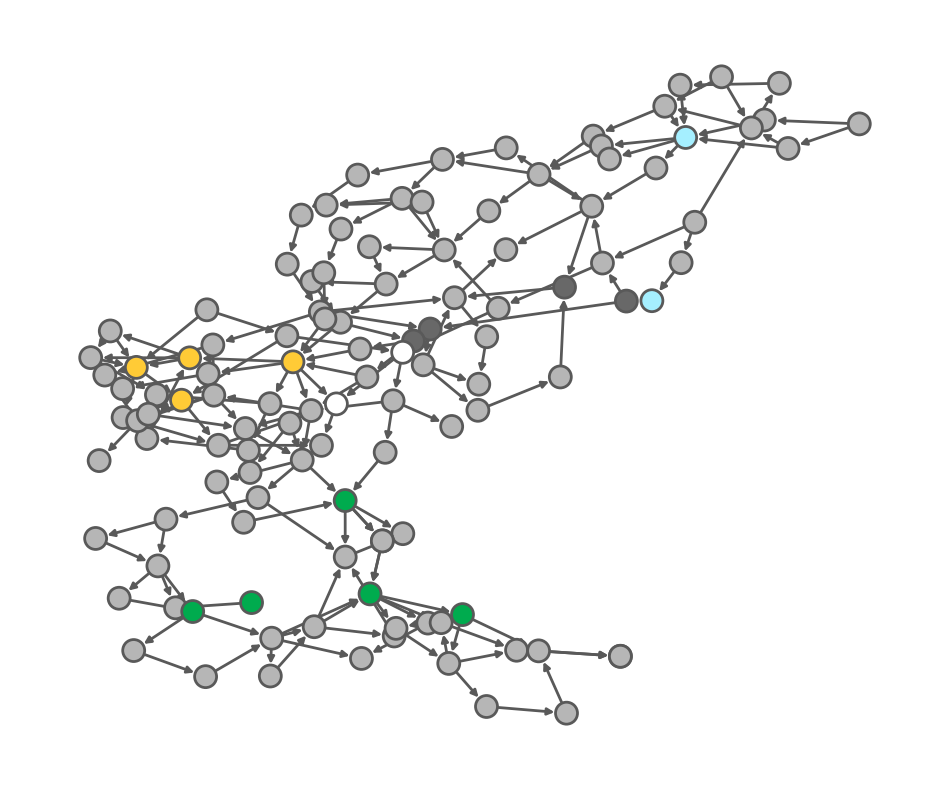

In [24]:
visualize_network(network)

The IEEE-118 network has 18 generators, of which:
- 2 hydro plants (cyan)
- 4 coal plants (dark gray)
- 4 solarfarms (yellow)
- 2 windmills (white)
- 6 gas plants (green)

Moreover, the network has 100 load nodes (gray). Each node has the following parameters:
- `node_id`
- `d`: demand
- `p_min`: minimum production capacity
- `p_max`: maximum production capacity
- `c_var`: variable production costs
- `is_generator`: boolean value to indicate whether the node is a generator or not
- `energy_type`: the type of energy used for electricity production

All generator nodes can filtered by the `is_generator` parameter. All generators have a zero demand $d_i=0$. For the renewable energy sources (i.e., hydro, solar and wind) there are no variable costs `c_var`. For solar and wind, the production is fixed, i.e., `p_min = p_max`, meaning that all available solar and wind energy must be produced.

In [25]:
example_nodes = network["nodes"]
example_nodes[example_nodes.is_generator]

,d,p_min,p_max,c_var,is_generator,energy_type
node_id,,,,,,
9,0.0,0.000000,400.000000,0.000000,True,hydro
11,0.0,0.000000,200.000000,0.000000,True,hydro
24,0.0,0.000000,397.800000,28.948321,True,coal
25,0.0,0.000000,873.000000,22.220980,True,coal
30,0.0,0.000000,612.000000,25.993982,True,coal
45,0.0,0.000000,720.000000,24.202306,True,coal
48,0.0,0.000000,0.000000,0.000000,True,solar
53,0.0,0.000000,0.000000,0.000000,True,solar
58,0.0,0.000000,0.000000,0.000000,True,solar


For the load nodes, the only important parameter is the demand $d_i \geq 0$. All other parameters are either zero, `False`, or an empty string `''`.

In [26]:
example_nodes[~example_nodes.is_generator]

,d,p_min,p_max,c_var,is_generator,energy_type
node_id,,,,,,
0,28.186145,0.0,0.0,0.0,False,
1,10.921628,0.0,0.0,0.0,False,
2,22.884795,0.0,0.0,0.0,False,
3,21.961682,0.0,0.0,0.0,False,
4,0.000000,0.0,0.0,0.0,False,
...,...,...,...,...,...,...
113,4.396000,0.0,0.0,0.0,False,
114,11.864042,0.0,0.0,0.0,False,
115,108.311328,0.0,0.0,0.0,False,


### Edges

The IEEE-118 network has 179 edges. Each edge has the following parameters:
- `node_id1`: first node of a given edge
- `node_id2`: second node of a given edge
- `b`: the line susceptance, and
- `f_max`: the maximum edge capacity.

In [27]:
edges_df

b  f_max
node_id1 node_id2                 
0        1          10.0100    271
         2          23.5849    271
3        4         125.3133    316
2        4           9.2593    315
4        5          18.5185    316
...                     ...    ...
64       65         28.9059   1427
67       68         28.9059   1427
80       79         28.9059   1427
86       85          4.8216    253
67       115       246.9136  12992

[179 rows x 2 columns]

### Instances
Since the OPF problem is solved every 15 minutes in practice, you will be given `24 * 4 = 96` network instances that need to be solved, hence solving an entire day's worth of OPF problems. The first instance thus corresponds to the power generation within time window `[00:00, 00:15]`, the second instance corresponds to `[00:15, 00:30]`, and so on. The data takes into account a realistic demand and (renewable energy) generation pattern. We assume that the decisions in each time window are independent of the previous and subsequent time windows, so every 15 minutes a new OPF instance is solved independently.

The network instances are stored in the variable `I` as a list and can be accessed using indexing, i.e., `I[0]` gives the first network instance and `I[95]` gives the 96th network instance.

---

# Solving OPF
Observe that the stated OPF problem contains absolute decision values. We first rewrite the OPF problem into a linear optimization problem.

$$\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i \\
\text{s.t.} & \sum_{j: (i, j) \in E} f^+_{ij} - f^-_{ij} - \sum_{j: (j, i) \in E} f^+_{ji} - f_{ji}^- = p_i - d_i & \forall \, i \in V,\\
& f^+_{ij} - f^-_{ij} =  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E, \\
            & f^+_{ij} + f^-_{ij} \leq  f_{ij}^{\max}    & \forall (i, j) \in E,\\
            & p_{i}^{\min } \leq p_{i} \leq p_{i}^{\max }         & \forall i \in V, \\
            & p_i \in \mathbb{R}_{\geq 0}        & \forall i \in V,                \\
            & \theta_i \in \mathbb{R} & \forall i \in V, \\
            & f_{ij}^+, f_{ij}^- \in \mathbb{R}                 & \forall (i, j) \in E                \\
\end{array}
\end{align}$$

We then implement the model using `AMPL` and solve it for all instances `I[0]` to `I[95]`, reporting the average objective value across all the 96 instances.

In [28]:
%%writefile opf1.mod

# Indexing sets
set NODES;
set EDGES within {NODES,NODES};

# Parameters
param d{NODES};
param p_min{NODES};
param p_max{NODES};
param c_var{NODES};
param is_generator{NODES};
param energy_type{NODES} symbolic;

param b{EDGES};
param f_max{EDGES};

# Declare decision variables
var p{i in NODES} >= p_min[i], <= p_max[i];
var theta{NODES};
var fabs{(i,j) in EDGES} >= 0, <= f_max[i, j];
var fp{EDGES} >= 0;
var fm{EDGES} >= 0;

# Declare objective value
minimize energy_cost: sum{i in NODES: is_generator[i] == 1} c_var[i] * p[i];

# Auxiliary variables for incoming and outgoing flows
var incoming_flow{i in NODES} = sum{j in NODES: (j,i) in EDGES} (fp[j, i] - fm[j, i]);
var outgoing_flow{i in NODES} = sum{j in NODES: (i,j) in EDGES} (fp[i, j] - fm[i, j]);

# Constraints
s.t. flow_conservation{i in NODES}:
    outgoing_flow[i] - incoming_flow[i] == p[i] - d[i];

s.t. susceptance{(i,j) in EDGES}:
    fp[i, j] - fm[i, j] == b[i, j] * (theta[i] - theta[j]);

s.t. abs_flow{(i,j) in EDGES}:
    fabs[i, j] == fp[i, j] + fm[i, j];

Overwriting opf1.mod


In [29]:
def OPF1(network):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - total energy dispatching cost
    """

    nodes = network["nodes"]
    edges = network["edges"]

    m = AMPL()
    m.read("opf1.mod")

    m.set_data(nodes, "NODES")
    m.set_data(edges, "EDGES")

    m.option["solver"] = SOLVER
    m.solve()

    return m.obj["energy_cost"].value()

In [30]:
OPF1_results = [OPF1(instance) for instance in I]
print(f"The average objective value over all instances is: {np.mean(OPF1_results):.2f}")

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25556.38586
527 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25291.14543
524 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25014.46578
517 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 24033.92447
547 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 24607.51391
526 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23894.80106
523 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23539.85465
522 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23344.3297
532 simplex iterations
0 barrier iterations
 
H

# Strict fossil fuel policy pt.1
Gas and coal plants emit CO2, while renewable energy sources are carbon neutral. For this reason, the Dutch government has decided to constrain the number of active fossil-fuel-based power plants for the generation of electricity. More specifically, a maximum of 2 gas plants and 1 coal plant may be *active* during a single OPF instance. Any plant that is set *inactive* for a specific instance cannot produce any electricity.

We first write down the new model. To this end, we introduce new decision variables $x_i, i\in V$ to the model, which indicate whether a generator $i$ is active or inactive.

$$\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i \\
\text{s.t.} & \sum_{j: (i, j) \in E} f^+_{ij} - f^-_{ij} - \sum_{j: (j, i) \in E} f^+_{ji} - f_{ji}^- = p_i - d_i & \forall \, i \in V,\\
& f^+_{ij} - f^-_{ij} =  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E, \\
& f^{abs}_{ij} = f^+_{ij} + f^-_{ij}, & \forall \, (i, j) \in E, \\
            & f_{ij}^{abs} \leq  f_{ij}^{\max}    & \forall (i, j) \in E,\\
            & p_{i}^{\min } x_i \leq p_{i} \leq p_{i}^{\max } x_i        & \forall i \in V, \\
            & \sum_{i \in \mathcal{G}_{\text{gas}}} x_i \leq 2 & \\
            & \sum_{i \in \mathcal{G}_{\text{coal}}} x_i \leq 1 &  \\
            & p_i \in \mathbb{R}_{\geq 0}        & \forall i \in V,                \\
            & \theta_i \in \mathbb{R} & \forall i \in V, \\
            & f_{ij} \in \mathbb{R}                 & \forall (i, j) \in E                \\
            & x_i  \in \{0, 1\} & \forall i \in V\\
\end{array}
\end{align}$$

We then implement the new model using `AMPL` and solve it for all instances `I[0]` to `I[95]`, reporting the average objective value across the instances.

In [31]:
%%writefile opf2.mod

# Indexing sets
set NODES;
set EDGES within {NODES,NODES};

# Parameters
param d{NODES};
param p_min{NODES};
param p_max{NODES};
param c_var{NODES};
param is_generator{NODES};
param energy_type{NODES} symbolic;

param b{EDGES};
param f_max{EDGES};

param max_gas_plants;
param max_coal_plants;

# Declare decision variables
var p{i in NODES} >= 0;
var theta{NODES};
var x{NODES} binary;
var fabs{(i,j) in EDGES} >= 0, <= f_max[i, j];
var fp{EDGES} >= 0;
var fm{EDGES} >= 0;

# Declare objective value
minimize energy_cost: sum{i in NODES: is_generator[i] == 1} c_var[i] * p[i];

# Auxiliary variables for incoming and outgoing flows
var incoming_flow{i in NODES} = sum{j in NODES: (j,i) in EDGES} (fp[j, i] - fm[j, i]);
var outgoing_flow{i in NODES} = sum{j in NODES: (i,j) in EDGES} (fp[i, j] - fm[i, j]);

# Constraints
s.t. flow_conservation{i in NODES}:
    outgoing_flow[i] - incoming_flow[i] == p[i] - d[i];

s.t. susceptance{(i,j) in EDGES}:
    fp[i, j] - fm[i, j] == b[i, j] * (theta[i] - theta[j]);

s.t. abs_flow{(i,j) in EDGES}:
    fabs[i, j] == fp[i, j] + fm[i, j];

s.t. generation_upper_bound{i in NODES}: p[i] <= p_max[i] * x[i];
s.t. generation_lower_bound{i in NODES}: p[i] >= p_min[i] * x[i];

s.t. gas_plants_limit: sum{i in NODES: energy_type[i] == 'gas'} x[i] <= max_gas_plants;
s.t. coal_plants_limit: sum{i in NODES: energy_type[i] == 'coal'} x[i] <= max_coal_plants;

Overwriting opf2.mod


In [32]:
def OPF2(network, max_gas_plants, max_coal_plants):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - total energy dispatching cost
    """

    nodes = network["nodes"]
    edges = network["edges"]

    m = AMPL()
    m.read("opf2.mod")

    m.set_data(nodes, "NODES")
    m.set_data(edges, "EDGES")

    m.param["max_gas_plants"] = max_gas_plants
    m.param["max_coal_plants"] = max_coal_plants

    m.option["solver"] = SOLVER
    m.solve()

    return m.obj["energy_cost"].value()

In [33]:
max_gas_plants = 2
max_coal_plants = 1
OPF2_results = [OPF2(instance, max_gas_plants, max_coal_plants) for instance in I]
print(f"The average objective value over all instances is: {np.mean(OPF2_results):.2f}")

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 32014.85844
578 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 31513.92689
576 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 30885.43208
569 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 28881.74194
558 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 30037.14784
553 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 28659.49442
730 simplex iterations
3 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 28098.31029
706 simplex iterations
3 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 27643.13369
737 simplex iterations
3 branching nodes
 
HiGHS 1.5.3: 

# Strict fossil fuel policy pt.2
The restriction on the number of gas and coal plants may pose a threat to the availability of electricity production when renewable energy sources fail to deliver. For this reason, the grid operators have decided to slightly change the constraint that was introduced for OPF2. If the total production of energy from renewable energy sources (i.e., solar, wind and hydro) is above 1000, then the number of gas and coal plants is restricted to 2 and 1, respectively. Otherwise, the restriction on the number of gas and coal plants is lifted. These constraints can be modeled as *either-or* constraints.
  
We first write down the new model, using big-$M$ constraints to model the either-or constraint.

$$\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i \\
\text{s.t.} & \sum_{j: (i, j) \in E} f^+_{ij} - f^-_{ij} - \sum_{j: (j, i) \in E} f^+_{ji} - f_{ji}^- = p_i - d_i & \forall \, i \in V,\\
& f^+_{ij} - f^-_{ij} =  b_{ij}(\theta_i - \theta_j), & \forall \, (i, j) \in E, \\
& f^{abs}_{ij} = f^+_{ij} + f^-_{ij}, & \forall \, (i, j) \in E, \\
            & f_{ij}^{abs} \leq  f_{ij}^{\max}    & \forall (i, j) \in E,\\
            & p_{i}^{\min } x_i \leq p_{i} \leq p_{i}^{\max } x_i        & \forall i \in V, \\
            & \sum_{i \in \mathcal{G}_{\text{gas}}} x_i \leq 2 + (1-y)M_0 & \\
            & \sum_{i \in \mathcal{G}_{\text{coal}}} x_i \leq 1 + (1-y)M_1 &  \\
            & \sum_{i \in \mathcal{G}_\text{solar}} p_i + \sum_{i \in \mathcal{G}_\text{wind}} p_i + \sum_{i \in \mathcal{G}_\text{hydro}} p_i \leq 1000 + yM_2&\\
            & p_i \in \mathbb{R}_{\geq 0}        & \forall i \in V,                \\
            & \theta_i \in \mathbb{R} & \forall i \in V, \\
            & f_{ij} \in \mathbb{R}                 & \forall (i, j) \in E                \\
            & x_i  \in \{0, 1\} & \forall i \in V\\
            & y \in \{0, 1\} &\\
\end{array}
\end{align}$$

We now implement the new model using `AMPL` and solve it for all instances `I[0]` to `I[95]`, reporting the average objective value across the instances.

In [34]:
%%writefile opf3.mod

# Indexing sets
set NODES;
set EDGES within {NODES,NODES};

# Parameters
param d{NODES};
param p_min{NODES};
param p_max{NODES};
param c_var{NODES};
param is_generator{NODES};
param energy_type{NODES} symbolic;

param b{EDGES};
param f_max{EDGES};

param max_gas_plants;
param max_coal_plants;

# Big-Ms
param M0;
param M1;
param M2;

# Declare decision variables
var p{i in NODES} >= 0;
var theta{NODES};
var x{NODES} binary;
var fabs{(i,j) in EDGES} >= 0, <= f_max[i, j];
var fp{EDGES} >= 0;
var fm{EDGES} >= 0;
var y binary;

# Declare objective value
minimize energy_cost: sum{i in NODES: is_generator[i] == 1} c_var[i] * p[i];

# Auxiliary variables for incoming and outgoing flows
var incoming_flow{i in NODES} = sum{j in NODES: (j,i) in EDGES} (fp[j, i] - fm[j, i]);
var outgoing_flow{i in NODES} = sum{j in NODES: (i,j) in EDGES} (fp[i, j] - fm[i, j]);

# Constraints
s.t. flow_conservation{i in NODES}:
    outgoing_flow[i] - incoming_flow[i] == p[i] - d[i];

s.t. susceptance{(i,j) in EDGES}:
    fp[i, j] - fm[i, j] == b[i, j] * (theta[i] - theta[j]);

s.t. abs_flow{(i,j) in EDGES}:
    fabs[i, j] == fp[i, j] + fm[i, j];

s.t. generation_upper_bound{i in NODES}: p[i] <= p_max[i] * x[i];
s.t. generation_lower_bound{i in NODES}: p[i] >= p_min[i] * x[i];

s.t. gas_plants_limit: sum{i in NODES: energy_type[i] == 'gas'} x[i] <= max_gas_plants + (1 - y) * M0;

s.t. coal_plants_limit: sum{i in NODES: energy_type[i] == 'coal'} x[i] <= max_coal_plants + (1 - y) * M1;

s.t. renewable_energy_production:
    sum{i in NODES: energy_type[i] in {'solar', 'wind', 'hydro'}} p[i] <= 1000 + y * M2;

Overwriting opf3.mod


In [35]:
def OPF3(network, max_gas_plants, max_coal_plants):
    """
    Input:
    - network: a dictionary containing:
      - a dictionary of nodes with a dictionary of attributes
      - a dictionary of edges with a dictionary of attributes

    Output:
    - total energy dispatching cost
    """

    nodes = network["nodes"]
    edges = network["edges"]

    m = AMPL()
    m.read("opf3.mod")

    m.set_data(nodes, "NODES")
    m.set_data(edges, "EDGES")

    m.param["max_gas_plants"] = max_gas_plants
    m.param["max_coal_plants"] = max_coal_plants

    m.param["M0"] = 4
    m.param["M1"] = 3
    m.param["M2"] = nodes["p_max"].sum()

    m.option["solver"] = SOLVER
    m.solve()

    return m.obj["energy_cost"].value()

In [36]:
OPF3_results = [OPF3(instance, max_gas_plants, max_coal_plants) for instance in I]
print(f"The average objective value over all instances is: {np.mean(OPF3_results):.2f}")

HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25556.38586
542 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25291.14543
541 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 25014.46578
532 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 24033.92447
532 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 24607.51391
527 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23894.80106
548 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23539.85465
531 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 23344.3297
555 simplex iterations
1 branching nodes
 
HiGHS 1.5.3: 

# Comparing the three models
For all three implemented models, we plot the objective values for all instances and explain the differences between the objective values in view of the different feasible regions.

In [37]:
objs = [OPF1_results, OPF2_results, OPF3_results]

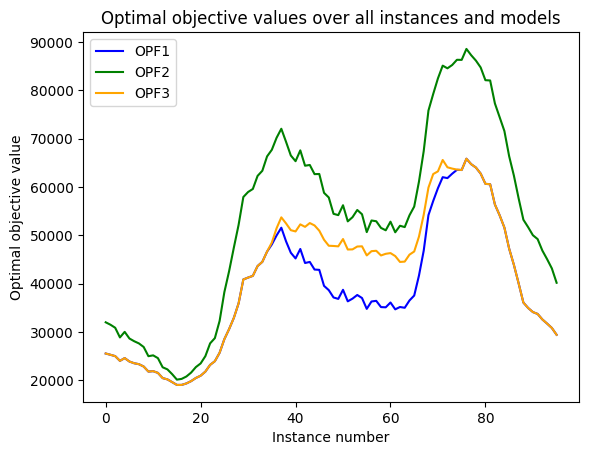

In [38]:
plt.plot(objs[0], color="blue", label="OPF1")
plt.plot(objs[1], color="green", label="OPF2")
plt.plot(objs[2], color="orange", label="OPF3")
plt.title("Optimal objective values over all instances and models")
plt.xlabel("Instance number")
plt.ylabel("Optimal objective value")
plt.legend()
plt.show()

The goal of the OPF problem is to minimize the total costs of dispatching energy. OPF1 is the original OPF formulation, whereas OPF2 and OPF3 are restricted versions of OPF1. This means that the feasible region of OPF1 is at least as large as OPF2 and OPF3, where we may assume that $x_i = 1$ for all the generators $i$.

If we let $F_1, F_2, F_3$ denote the feasible region of OPF1, OPF2 and OPF3, then we observe that which explains that the optimal objective value of OPF1 always remains below the optimal objectives values of OPF2 and OPF3.

The most important observation to make is that based on the problem descriptions, we would expect OPF2 to take on the objective values of OPF1 or OPF3, depending on which of the either-or-constraints are activated.
- OPF3 uses expensive generators, and possibly not all the renewable energy
- OPF2 does only uses 1000 renewable energy power, because then it may keep using all the gas and coal generators.
- OPF1 uses all renewable energy at all times, because it has the flexibility to use all generators in order to mitigate operational restrictions due to line flows.